# 8장 머신러닝 응용
## 8.3 시카고외식업체

In [1]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

# 자료 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 모델 선택
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 성능지표
from sklearn.metrics import accuracy_score, plot_roc_curve 
from sklearn.metrics import plot_confusion_matrix, classification_report

# 파이프라인
from sklearn.pipeline import Pipeline, make_pipeline

# 시각화 툴
import scikitplot as skplt

# 모델저장
from joblib import dump, load

In [2]:
df = pd.read_csv('../data/food-inspections.csv')
df.shape
df.to_pickle('../data/food-inspections.pkl')

(196825, 22)

In [3]:
df = pd.read_pickle('../data/food-inspections.pkl')
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2352683,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,CHICAGO,IL,60613.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,Risk 1 (High),2900 W 63RD ST,CHICAGO,IL,60629.0,...,Not Ready,NaN,41.779190,-87.695892,"{'latitude': '-87.69589237398256', 'longitude'...",NaN,NaN,NaN,NaN,NaN


In [4]:
pd.DataFrame({'결측치수':df.isnull().sum(), '고유값수':df.nunique(),
              '자료형태':df.dtypes})

,결측치수,고유값수,자료형태
Inspection ID,0,196676,int64
DBA Name,0,27621,object
AKA Name,2458,26346,object
License #,17,37464,float64
Facility Type,4768,491,object
Risk,69,4,object
Address,0,18081,object
City,139,71,object
State,42,4,object
Zip,50,112,float64


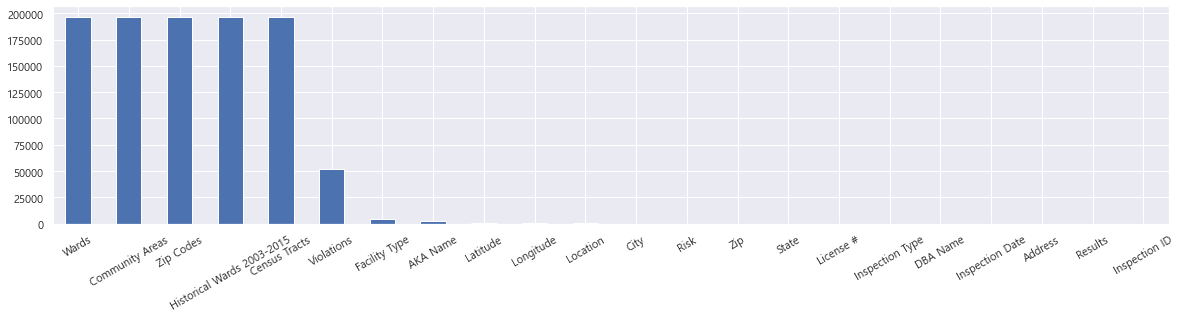

In [5]:
df.isnull().sum().sort_values(ascending=False).plot(kind='bar', rot='30', figsize=(20,4))

In [6]:
df = df.drop(['Inspection ID', 'AKA Name', 'Address', 'City', 'Wards', 
              'Community Areas', 'Zip Codes', 'Historical Wards 2003-2015', 
              'Census Tracts', 'Violations', 'Location', 'State'], axis=1)
df = df.dropna()
df.shape
pd.DataFrame({'결측치수':df.isnull().sum(), '고유값수':df.nunique(),
              '자료형태':df.dtypes})

(191304, 10)

,결측치수,고유값수,자료형태
DBA Name,0,23978,object
License #,0,32995,float64
Facility Type,0,480,object
Risk,0,4,object
Zip,0,63,float64
Inspection Date,0,2519,object
Inspection Type,0,106,object
Results,0,7,object
Latitude,0,16006,float64
Longitude,0,16006,float64


In [7]:
df['Results'].value_counts().nlargest(3)
df['Results'].value_counts(normalize=True).round(2)

Pass                  105367
Fail                   37569
Pass w/ Conditions     27314
Name: Results, dtype: int64

Pass                    0.55
Fail                    0.20
Pass w/ Conditions      0.14
Out of Business         0.07
No Entry                0.03
Not Ready               0.01
Business Not Located    0.00
Name: Results, dtype: float64

In [8]:
df= df[(df['Results']=='Pass') |(df['Results']=='Fail') |\
       (df['Results']=='Pass w/ Conditions')]
map_dict = {'Pass': 0, 'Pass w/ Conditions': 0, 'Fail': 1}
df['Results'] = df['Results'].map(map_dict).values
df['Results'].value_counts()
df['Results'].value_counts(normalize=True)

0    132681
1     37569
Name: Results, dtype: int64

0    0.77933
1    0.22067
Name: Results, dtype: float64

In [9]:
# 점검회수와 위반회수를 추출하기 위해 두개의 컬럼을 만듦
df['점검'] = 1
df['위반'] = 0
df.loc[df['Results']== 1, '위반'] = 1
df.위반.sum()

37569

102

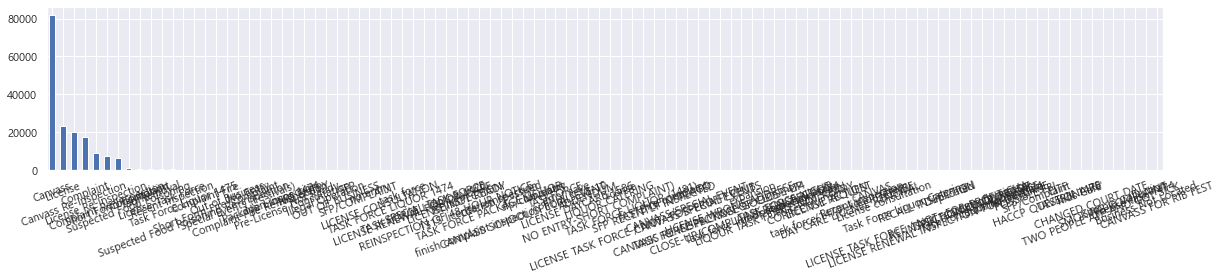

In [10]:
df['Inspection Type'].nunique()
df['Inspection Type'].value_counts().plot(kind='bar', rot = '20', figsize=(20,3))

Canvass                    82039
License                    23444
Canvass Re-Inspection      20330
Complaint                  17356
License Re-Inspection       8883
Complaint Re-Inspection     7455
Short Form Complaint        6632
Other                       4111
Name: Inspection Type, dtype: int64

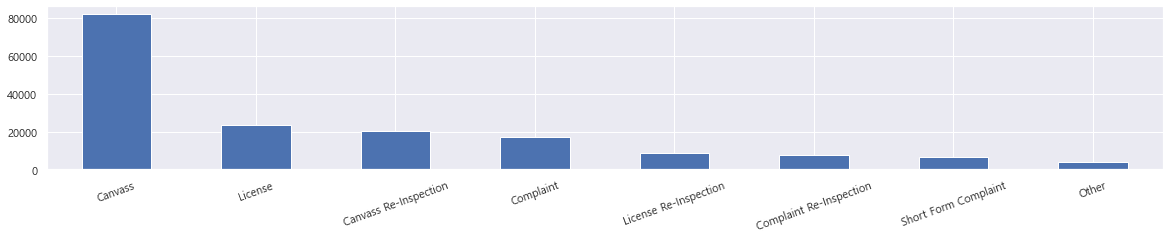

In [11]:
top_seven = df['Inspection Type'].value_counts().nlargest(7).index 
df['Inspection Type'] = df['Inspection Type'].\
where(df['Inspection Type'].isin(top_seven), other = "Other")
df['Inspection Type'].value_counts()
df['Inspection Type'].value_counts().plot(kind='bar', rot = '20', figsize=(20,3))

Restaurant                         115595
Grocery Store                       22096
School                              11495
Other                               10950
Children's Services Facility         2945
Bakery                               2532
Daycare (2 - 6 Years)                2386
Daycare Above and Under 2 Years      2251
Name: Facility Type, dtype: int64

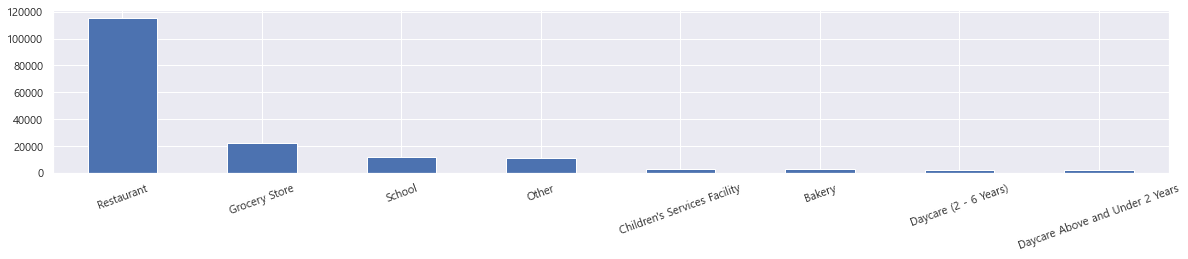

In [12]:
top_seven = df['Facility Type'].value_counts().nlargest(7).index 
df['Facility Type'] = df['Facility Type'].\
where(df['Facility Type'].isin(top_seven), other = "Other")
df['Facility Type'].value_counts()
df['Facility Type'].value_counts().plot(kind='bar', rot = '20', figsize=(20,3))

<Figure size 720x720 with 0 Axes>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

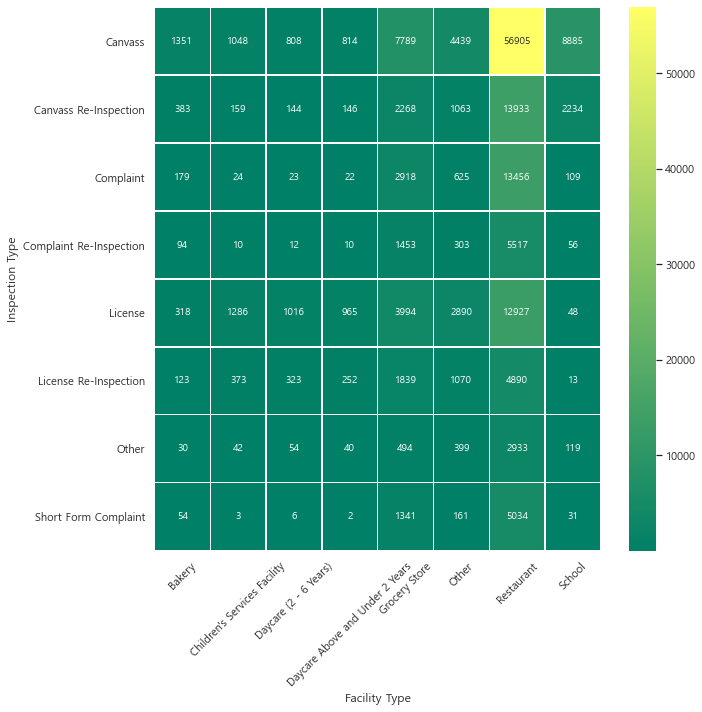

In [13]:
plt.figure(figsize=(10, 10))
data = df.groupby('Inspection Type')['Facility Type'].value_counts().unstack()
sns.heatmap(data=data, annot=True, fmt='.0f', linewidths=.5, cmap='summer')
plt.xticks(rotation=45)

In [14]:
df.Risk.value_counts(normalize=True)
df['Risk'] = df['Risk'].apply(lambda x: 'Risk 3 (Low)' if x == 'All' else x)
df.Risk.value_counts(normalize=True)

Risk 1 (High)      0.737633
Risk 2 (Medium)    0.193063
Risk 3 (Low)       0.069298
All                0.000006
Name: Risk, dtype: float64

Risk 1 (High)      0.737633
Risk 2 (Medium)    0.193063
Risk 3 (Low)       0.069304
Name: Risk, dtype: float64

<Figure size 1440x432 with 0 Axes>

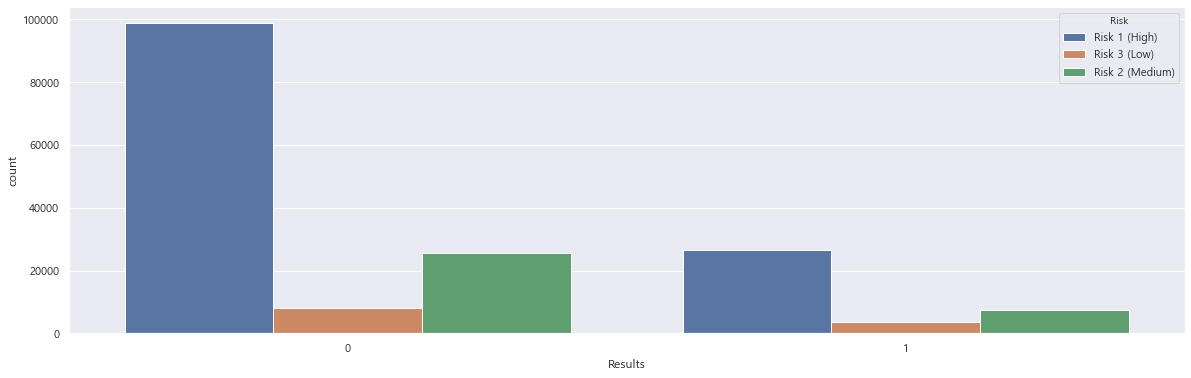

In [15]:
plt.figure(figsize=(20,6))
sns.countplot(data=df, x='Results', hue='Risk')

In [16]:
df['Date'] = pd.to_datetime(df['Inspection Date'])
df['Date'].min(), df['Date'].max()
df['Date'].dt.year.value_counts()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2019-12-04 00:00:00'))

2016    19776
2014    18528
2017    18405
2015    17815
2011    17430
2013    16998
2010    16893
2012    15893
2018    14762
2019    13750
Name: Date, dtype: int64

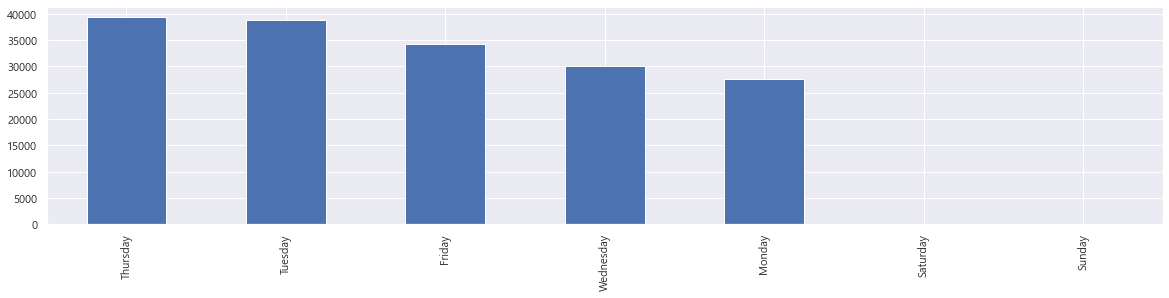

In [17]:
df['Date'].apply(lambda x: x.date().strftime('%A')).value_counts().plot(kind='bar',figsize=(20,4))

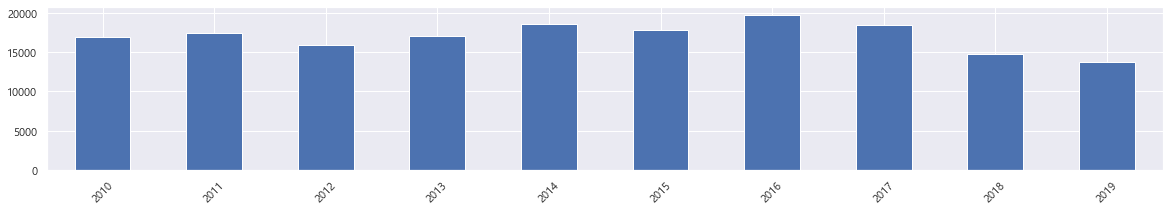

In [18]:
df['Date'].dt.year.value_counts().sort_index().plot(kind= 'bar',rot='45', figsize=(20,3))

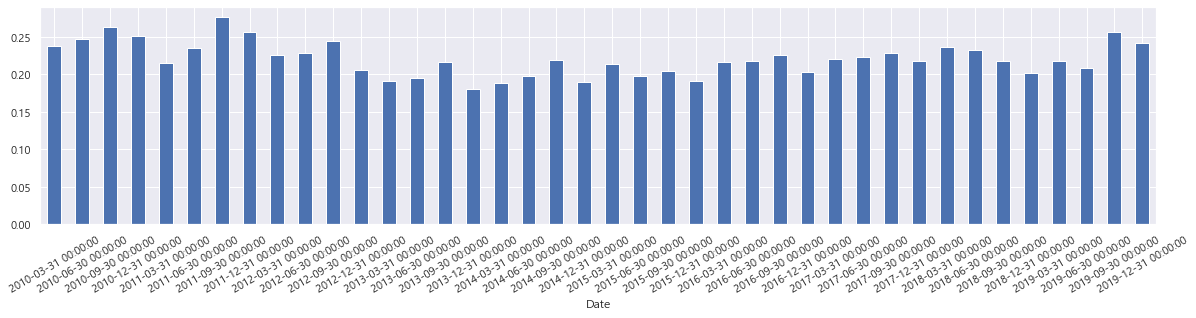

In [19]:
tf = df.set_index('Date')
tf['위반'].resample(rule='Q').mean().plot(kind='bar', rot='30', figsize=(20,4))

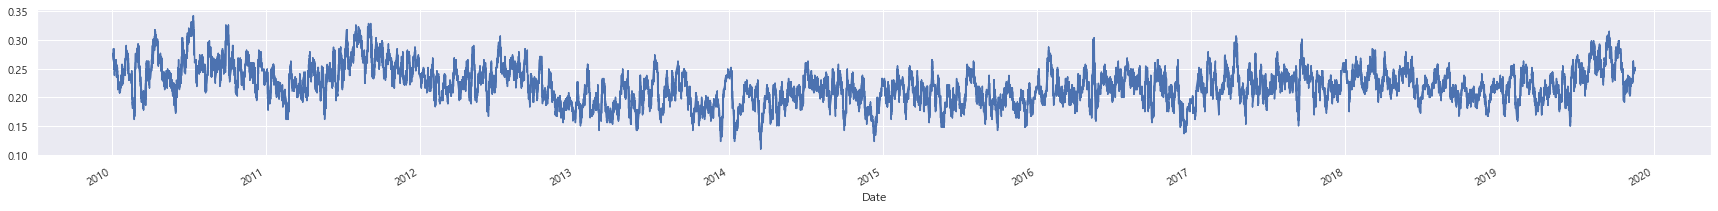

In [20]:
rolling = tf['위반'].rolling(window=365)
rolling.mean().plot(figsize=(30,3))

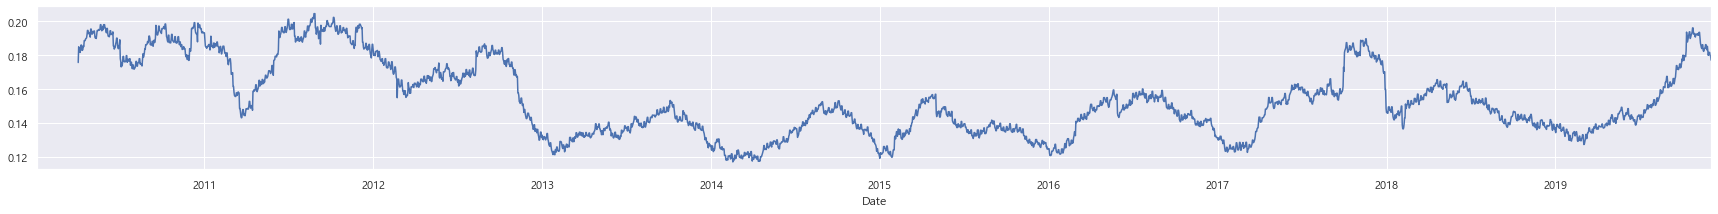

In [21]:
daily = df.set_index('Date').resample('D').sum()
daily['위반율/일'] = daily['위반']/daily['점검']
daily['위반율/일'] = daily['위반율/일'].fillna(0)
rolling = daily['위반율/일'].rolling(window=90)
rolling.mean().plot(figsize=(30,3))

([<matplotlib.patches.Wedge at 0x206937fc0c8>,
 [Text(-1.8675448312151706, 2.018607515938029, 'Risk 1 (High)'),
  Text(1.3874177564687828, -2.3743571696430026, 'Risk 2 (Medium)'),
  Text(2.685076353921077, -0.5940243880632304, 'Risk 3 (Low)')],
 [Text(-1.0186608170264566, 1.101058645057107, '73.8%'),
  Text(0.7567733217102453, -1.295103910714365, '19.3%'),
  Text(1.4645871021387693, -0.3240133025799439, '6.9%')])

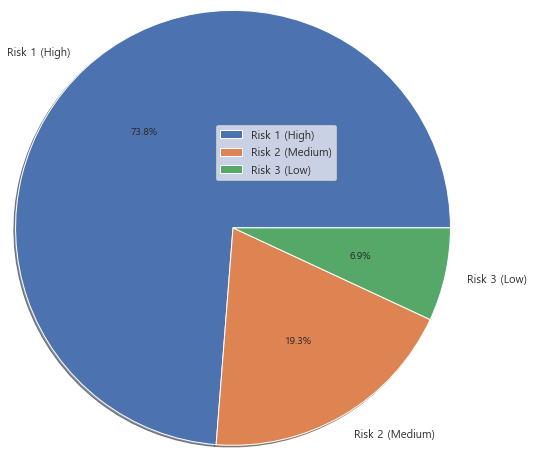

In [22]:
plt.pie(df['Risk'].value_counts(),labels=df['Risk'].value_counts().index,
        autopct='%1.1f%%', shadow=True, radius=2.5)
plt.legend(loc = 'best')

In [23]:
df = df.assign(year=df['Date'].dt.year, month=df['Date'].dt.month)

Text(0.5, 1.0, 'The counts of inspection by year')

Text(0.5, 1.0, 'The counts of inspection by month')

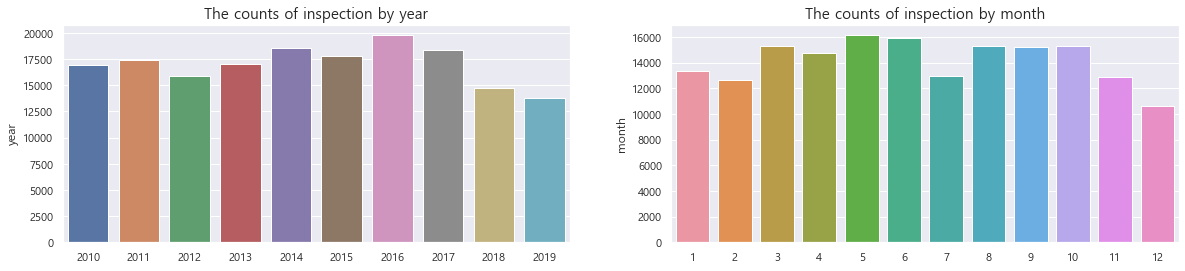

In [24]:
fig,ax=plt.subplots(1,2,figsize=(20,4))
x=df.year.value_counts().index; y=df.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0])
ax[0].set_title("The counts of inspection by year",size=15)
x=df.month.value_counts().index; y=df.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[1])
ax[1].set_title("The counts of inspection by month",size=15)

<Figure size 720x720 with 0 Axes>

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

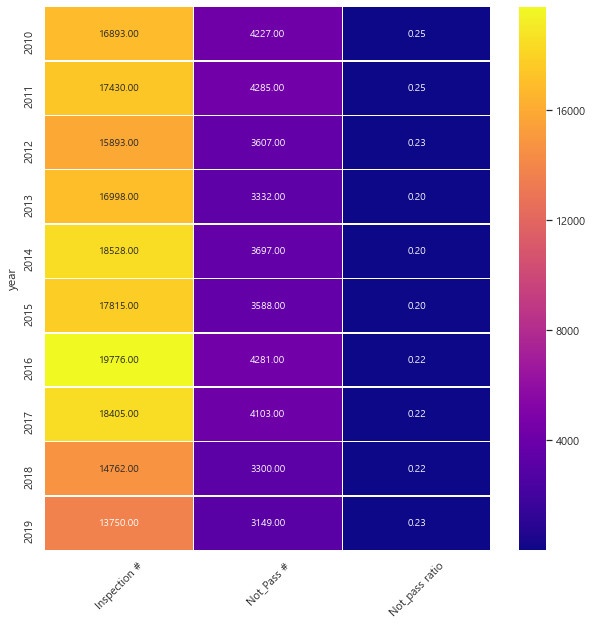

In [25]:
plt.figure(figsize=(10, 10))
sf = df.groupby('year')['Results'].agg(['size', 'sum', 'mean'])
sf.columns = ['Inspection #', 'Not_Pass #', 'Not_pass ratio']
sns.heatmap(data=sf, annot=True, fmt='.2f', linewidths=.5, cmap='plasma')
plt.xticks(rotation=45)

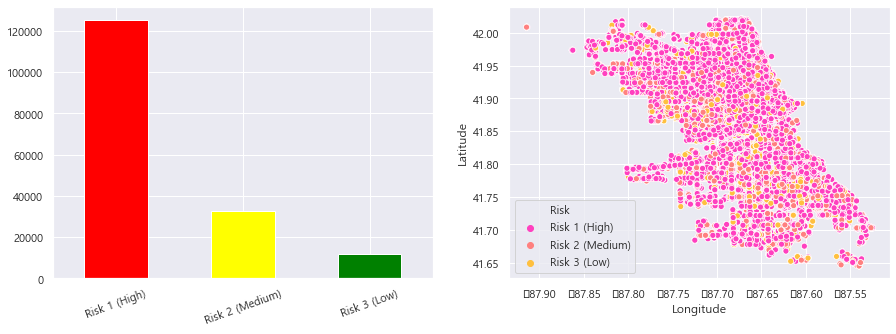

In [26]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
df.Risk.value_counts().plot(kind='bar', rot='20', 
                            color=['red','yellow','green', 'blue'], ax=ax[0])
sns.scatterplot(x='Longitude', y='Latitude', hue='Risk', 
                palette='spring', data=df.sample(frac=0.5))

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df['Latitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Latitude'] = scaler.transform(df['Latitude'][:, np.newaxis])
scaler.fit(df['Longitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Longitude'] = scaler.transform(df['Longitude'][:, np.newaxis])

df['far']=df['Latitude']*0.4 + df['Longitude'] # 위도(latitude) 경도(longitude)
df['far_q'] = pd.qcut(df['far'], q = 5, labels = np.arange(5)) 

MinMaxScaler()

MinMaxScaler()

,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,점검,위반,Date,year,month,far,far_q
0,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),60613.0,2019-12-04T00:00:00.000,License Re-Inspection,0,0.803540,0.665359,1,0,2019-12-04,2019,12,0.986775,3
1,CHILI'S T-I,34169.0,Restaurant,Risk 1 (High),60666.0,2019-12-04T00:00:00.000,Canvass,0,0.966716,0.000000,1,0,2019-12-04,2019,12,0.386686,0
3,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,Risk 1 (High),60618.0,2019-12-04T00:00:00.000,License,0,0.782418,0.518532,1,0,2019-12-04,2019,12,0.831500,1
4,PORTAGE PARK DAY NURSERY,2215815.0,Children's Services Facility,Risk 1 (High),60641.0,2019-12-04T00:00:00.000,Canvass,0,0.800742,0.394792,1,0,2019-12-04,2019,12,0.715089,0
5,AMARIT RESTAURANT,1801618.0,Restaurant,Risk 1 (High),60605.0,2019-12-04T00:00:00.000,Canvass Re-Inspection,0,0.610560,0.732203,1,0,2019-12-04,2019,12,0.976427,3


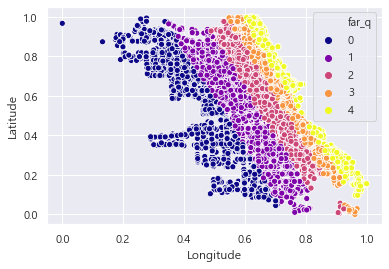

In [28]:
df.head()
sns.scatterplot(x='Longitude', y='Latitude', hue='far_q', palette='plasma',
                legend='full', data=df.sample(frac=0.3))   

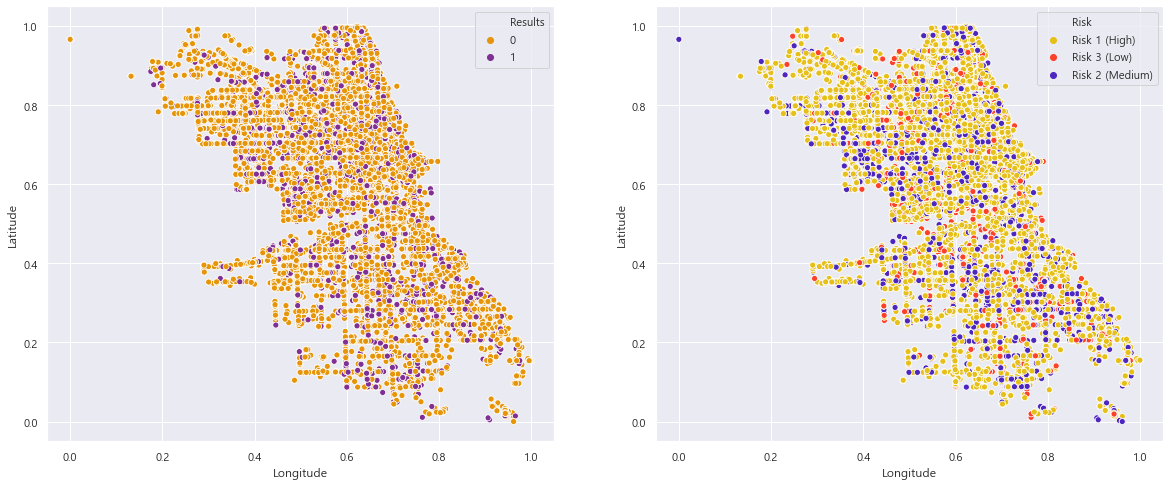

In [29]:
fig,ax=plt.subplots(1,2,figsize=(20,8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Results', palette='CMRmap_r', legend='full', data=df.sample(frac=0.3), ax=ax[0])   
sns.scatterplot(x='Longitude', y='Latitude', hue='Risk', palette='CMRmap_r', legend='full', data=df.sample(frac=0.3))   

In [30]:
map_dict = {'Risk 1 (High)':3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1}
df['Risk'] = df['Risk'].map(map_dict)

Text(0.5, 1.0, 'Fail ratios between month & year')

Text(0.5, 1.0, 'Risk ranks between year & off shore distance')

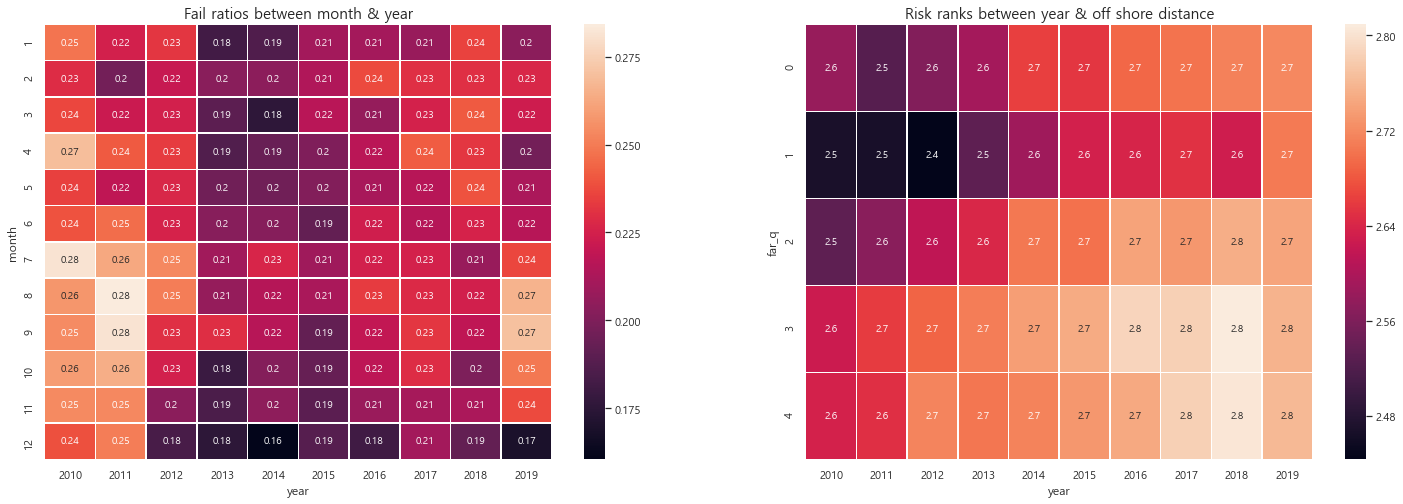

In [31]:
fig,ax=plt.subplots(1,2,figsize=(25,8)) 
tf = pd.pivot_table(df, index='month',columns='year', values='Results')
sns.heatmap(tf, annot=True, linewidths=.5,  ax=ax[0])
ax[0].set_title('Fail ratios between month & year',size=15)
af = pd.pivot_table(df, index='far_q',columns='year', values='Risk')
sns.heatmap(af, annot=True, linewidths=.5,  ax=ax[1])
ax[1].set_title('Risk ranks between year & off shore distance',size=15)

In [32]:
import uuid
uni_list = []
for i in range(df['Latitude'].nunique()) :
    uni_list.append(str(uuid.uuid4().fields[-1])[:10]) # 10자리는 되어야
tf = pd.DataFrame([uni_list]).T
tf['Latitude'] = df['Latitude'].unique()
tf.columns = ['ID', 'Latitude']
tf.nunique()

ID          15798
Latitude    15798
dtype: int64

In [33]:
df = pd.merge(df, tf, on = 'Latitude', how = 'left')
df.head(10)

,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,점검,위반,Date,year,month,far,far_q,ID
0,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3,60613.0,2019-12-04T00:00:00.000,License Re-Inspection,0,0.803540,0.665359,1,0,2019-12-04,2019,12,0.986775,3,2591418199
1,CHILI'S T-I,34169.0,Restaurant,3,60666.0,2019-12-04T00:00:00.000,Canvass,0,0.966716,0.000000,1,0,2019-12-04,2019,12,0.386686,0,1181627234
2,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3,60618.0,2019-12-04T00:00:00.000,License,0,0.782418,0.518532,1,0,2019-12-04,2019,12,0.831500,1,1796019883
3,PORTAGE PARK DAY NURSERY,2215815.0,Children's Services Facility,3,60641.0,2019-12-04T00:00:00.000,Canvass,0,0.800742,0.394792,1,0,2019-12-04,2019,12,0.715089,0,2726462881
4,AMARIT RESTAURANT,1801618.0,Restaurant,3,60605.0,2019-12-04T00:00:00.000,Canvass Re-Inspection,0,0.610560,0.732203,1,0,2019-12-04,2019,12,0.976427,3,2491980898
5,CHIPOTLE MEXICAN GRILL,2670643.0,Restaurant,3,60613.0,2019-12-04T00:00:00.000,License Re-Inspection,0,0.803540,0.665359,1,0,2019-12-04,2019,12,0.986775,3,2591418199
6,NAIBOA LATIN STORE,2698776.0,Grocery Store,1,60657.0,2019-12-04T00:00:00.000,License,0,0.792684,0.671488,1,0,2019-12-04,2019,12,0.988561,4,4366496087
7,JAMIESON,23931.0,School,3,60659.0,2019-12-04T00:00:00.000,Canvass,0,0.903159,0.549305,1,0,2019-12-04,2019,12,0.910568,2,9750556730
8,GATEWAY MONTESSORI SCHOOL,2506383.0,Children's Services Facility,3,60641.0,2019-12-04T00:00:00.000,Canvass,0,0.824153,0.480110,1,0,2019-12-04,2019,12,0.809771,1,2814301123
9,BLUE LINE,1170410.0,Restaurant,3,60622.0,2019-12-03T00:00:00.000,Canvass Re-Inspection,0,0.703906,0.608320,1,0,2019-12-03,2019,12,0.889883,2,1982706189


In [34]:
df20 = df.groupby(['ID', 'year']).agg({'점검':['sum'], '위반':['sum']})
df20.columns = ['점검', '위반']
df20 = df20.reset_index()
df20.head()

,ID,year,점검,위반
0,1000004717,2010,1,0
1,1000458243,2018,1,0
2,1000505023,2018,1,0
3,1000507996,2017,1,0
4,1000507996,2019,1,0


In [35]:
from itertools import product
df30 = pd.DataFrame(product(df['ID'].unique(), df['year'].unique()), 
                    columns=['ID','year'])
df30 .head(13)

,ID,year
0,2591418199,2019
1,2591418199,2018
2,2591418199,2017
3,2591418199,2016
4,2591418199,2015
5,2591418199,2014
6,2591418199,2013
7,2591418199,2012
8,2591418199,2011
9,2591418199,2010


In [36]:
df31 = (df30.merge(df20, how='left').sort_values(['ID','year']).reset_index(drop=True))

# 과거 5년간의 점검 위반 회수를 df에 생성, 점검이 없던 해(그 해 기준으로 과거 5년간의 점검 위반값을 알 수 있도록)도 데이터 생성됨
df32 = pd.DataFrame()
lags = range(1, 6)
#df31_grouped = df31.groupby(['ID'])
cols = ['점검', '위반']
for n in lags: 
    for col in cols:
        df32[f'{col} (n-{n})'] = df31.groupby(['ID'])[f'{col}'].shift(n)
df_A = df31.merge(df32, left_index=True, right_index=True)
df_A.head()

,ID,year,점검,위반,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
0,1000004717,2010,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000004717,2011,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000004717,2012,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1000004717,2013,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
4,1000004717,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN


In [37]:
df41 = df.sort_values(['ID','Date']).reset_index(drop=True)
df42 = df41.groupby(['ID','year']).agg({'점검':'cumsum', '위반':'cumsum'})
df43 = df41.merge(df42, left_index=True, right_index=True)
# 이번을 제외한 올해의 누적 점검횟수 위반횟수 계산
df43['점검_y'] = df43['점검_y'] - df43['점검_x']
df43['위반_y'] = df43['위반_y'] - df43['위반_x']
# df43['점검_x']은 모두 1이므로 제거
del df43['점검_x']
# 점검결과 1 --> 위반으로 설정
df_B = df43.rename(columns={'점검_y':'점검', '위반_y':'위반', '위반_x':'점검결과'})

In [38]:
df = df_B.merge(df_A, on=['ID', 'year'])
del df['점검_y']; del df['위반_y']

In [39]:
# Impute checklist with 'zero'
check = ['점검 (n-1)', '위반 (n-1)', '점검 (n-2)', '위반 (n-2)', '점검 (n-3)',
         '위반 (n-3)', '점검 (n-4)', '위반 (n-4)', '점검 (n-5)', '위반 (n-5)']
for i in check :
    df[i]= df[i].fillna(0)
df[check]

,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
170245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170247,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
170248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# object는 category 변환
for col in df.columns :
    if df[col].dtypes == 'object' :
        df[col] = df[col].astype('category')
df.rename(columns={'점검_x': '점검', '위반_x': '위반'}, inplace = True)

In [41]:
df[['DBA Name', 'ID', 'Date', '점검결과'] + check].head()

,DBA Name,ID,Date,점검결과,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
0,CARAMELA BAKERY,1000004717,2010-02-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TOVALA,1000458243,2018-10-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JUST PIZZA EXPRESS INC.,1000505023,2018-11-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BEST SUB CORNER INC,1000507996,2017-11-22,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BLAZING BURGER N WINGS LLC,1000507996,2019-01-28,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df = df.drop(['DBA Name', 'License #', 'Zip', 'Inspection Date', 'Results', 'Latitude', 
              'Longitude', 'Date', 'year', 'month', 'far'], axis=1)
df.set_index('ID', inplace =True)
print('The numbers of nan, inf & -inf : ', 
      df.isin([np.nan, np.inf, -np.inf]).any(1).sum())

The numbers of nan, inf & -inf :  0


In [43]:
df.to_pickle('D:/Book_파이썬도장깨기/output/chicago.pkl')

In [44]:
df.to_pickle('../data/chicago.pkl')

In [45]:
df.shape
df = df.sample(frac=0.1, random_state=11).copy()
df.shape

(170250, 17)

(17025, 17)

In [46]:
categorical_list = df.select_dtypes(include=['category']).columns
X = pd.get_dummies(df.drop(['점검결과'], axis=1), prefix= categorical_list)
y = df['점검결과']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,
                                          random_state = 11)

In [47]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
# Model evaluation
from sklearn.model_selection import cross_val_score, KFold
#Model evaluation metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss

from tqdm import tqdm_notebook
from scipy.stats import ks_2samp

In [48]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'Dtc': DecisionTreeClassifier(class_weight='balanced')})
classifiers.update({'RF': RandomForestClassifier(class_weight='balanced', 
                                                 n_estimators=30)})
classifiers.update({'SVC': SVC(class_weight='balanced', 
                               probability=True, max_iter=300)})

In [49]:
kf = KFold(n_splits=3)
results = {}
for classifier_label, classifier in classifiers.items():
    steps = [('scaler', StandardScaler()), ('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'Test recall_macro': recall_score(y_test, y_pred, average='macro'),
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
              'KS_pvalue': ks_2samp(y_test, y_pred)[1]
             }
 
    results.update({classifier_label: result})

In [50]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,Training recall_macro,Test recall_macro,AUROC,Average PR,F1-score,Accuracy,Log_loss,Brier_score,KS_pvalue
SVC,0.20258,0.5,0.486259,0.207673,0.361011,0.181971,0.527266,0.171756,0
LGR,0.56083,0.6242,0.676282,0.356222,0.422786,0.559787,0.641133,0.226354,3.61142e-72
RF,0.557245,0.556682,0.62804,0.308634,0.288136,0.562675,1.03747,0.190495,1.24265e-05
KNN,0.543706,0.547179,0.608402,0.281602,0.245115,0.542791,2.24791,0.187771,2.67288e-18
Dtc,0.55776,0.56194,0.563527,0.250481,0.332362,0.54961,8.32776,0.295776,2.52438e-06


In [51]:
grid = {
'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(5, 20, 10)],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'bootstrap': [True, False]
}

In [52]:
np.random.seed(1357)
kf = KFold(n_splits=5)
rf = RandomForestClassifier(random_state=11)
rf_random = RandomizedSearchCV(estimator= rf, 
                               param_distributions = grid, cv=kf)
y_predict = rf_random.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

0.7809104258443466

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2655
           1       0.53      0.05      0.09       750

    accuracy                           0.78      3405
   macro avg       0.66      0.52      0.49      3405
weighted avg       0.73      0.78      0.70      3405



ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000206E67E61C8>,
       classes=['Not_buy', 'Buy'], model=None)

0.6863425057649817

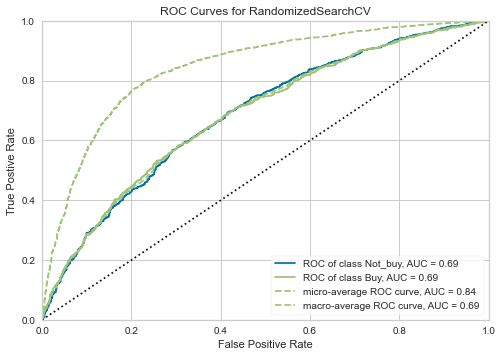

In [53]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf_random, classes=['Not_buy', 'Buy'])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

{'whiskers': [<matplotlib.lines.Line2D at 0x2068b494e48>,
 'caps': [<matplotlib.lines.Line2D at 0x2068b49cc08>,
 'boxes': [<matplotlib.lines.Line2D at 0x2068b494d08>,
 'medians': [<matplotlib.lines.Line2D at 0x20691df3588>,
 'fliers': [<matplotlib.lines.Line2D at 0x20691df3a08>,
 'means': []}

Text(0.5, 1.0, 'Permutation Importance of each feature')

Text(0, 0.5, 'Features')

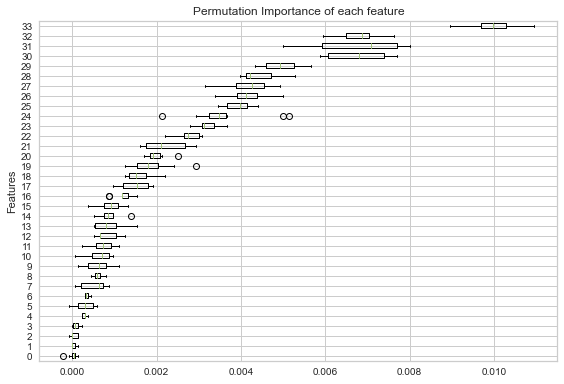

In [54]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_random.best_estimator_, 
                                X_train, y_train, n_repeats=10, random_state=0,
                                n_jobs=-1)
fig, ax = plt.subplots()
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=range(X.shape[1]))
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000020693FD5488>,
                   model=None)

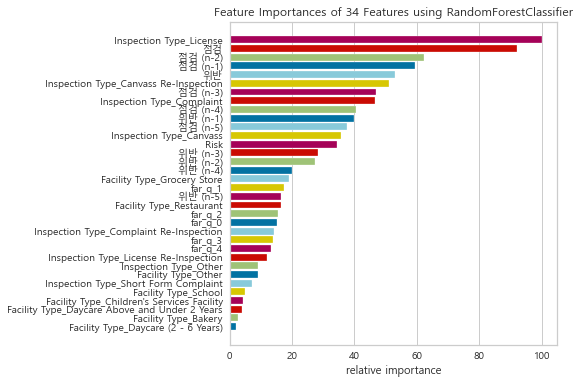

In [55]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['font.family']='Malgun Gothic'
viz = FeatureImportances(rf_random.best_estimator_)
viz.fit(X_train, y_train)
viz.show()

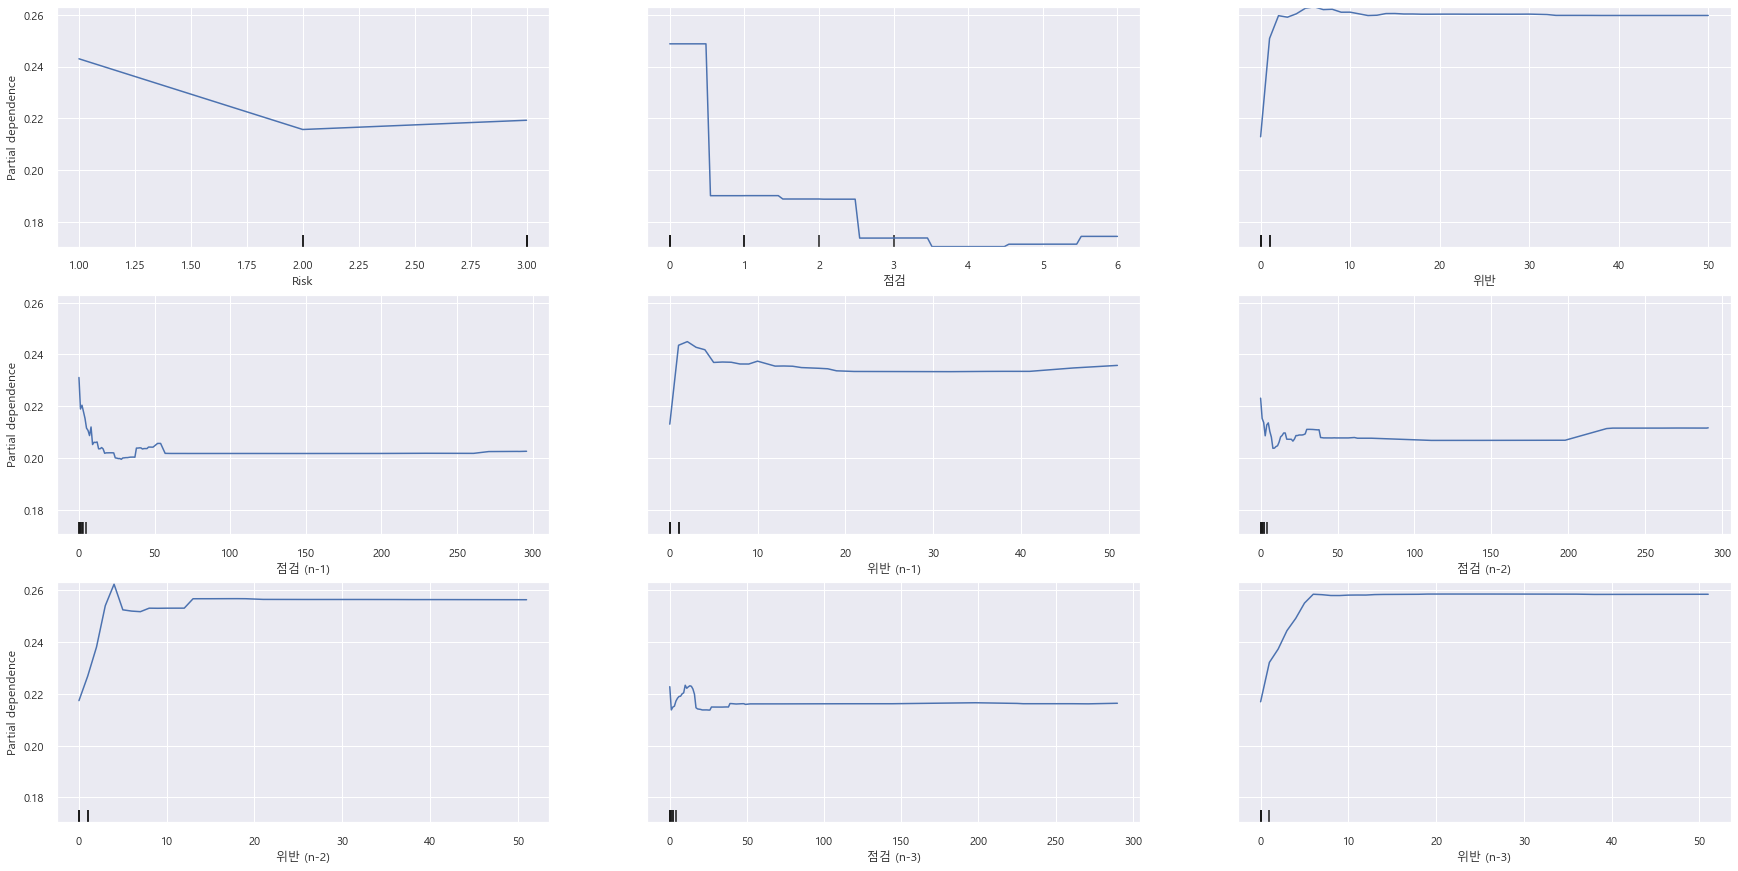

In [56]:
sns.set()
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
from sklearn.inspection import plot_partial_dependence
plt.rcParams["figure.figsize"] = (30,15)
features = X_train.columns[0:9]
plot_partial_dependence(rf_random.best_estimator_, X_train, features) 
fig.subplots_adjust(hspace=5)

In [71]:
X_test.shape[0]*.52

1770.6000000000001

DiscriminationThreshold(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000020695B74CC8>,
                        force_model=None, model=None)

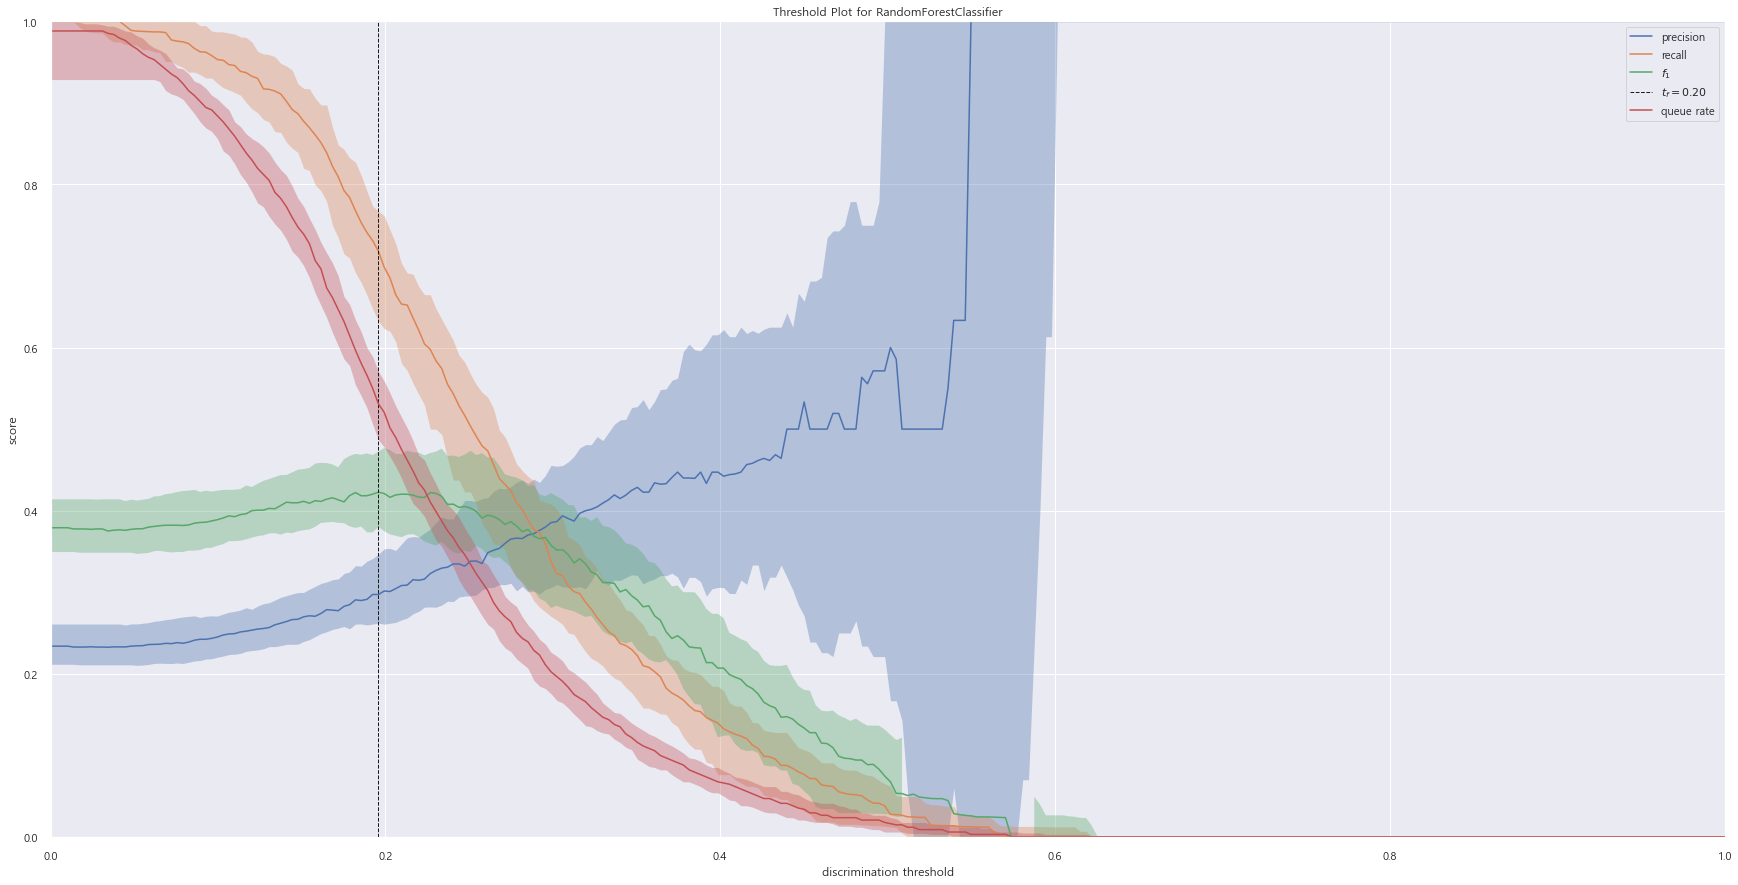

In [58]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(rf_random.best_estimator_)
visualizer.fit(X_test, y_test)  # Fit the training data to the visualizer
visualizer.poof()

In [59]:
from sklearn.model_selection import (KFold, StratifiedKFold, GroupKFold)
kf = KFold(n_splits=5)
for train, test in kf.split(X_train):
    print("%s %s" % (train, test))

[ 2724  2725  2726 ... 13617 13618 13619] [   0    1    2 ... 2721 2722 2723]
[    0     1     2 ... 13617 13618 13619] [2724 2725 2726 ... 5445 5446 5447]
[    0     1     2 ... 13617 13618 13619] [5448 5449 5450 ... 8169 8170 8171]
[    0     1     2 ... 13617 13618 13619] [ 8172  8173  8174 ... 10893 10894 10895]
[    0     1     2 ... 10893 10894 10895] [10896 10897 10898 ... 13617 13618 13619]


In [60]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
skf
for train_index, test_index in skf.split(X, y):
    print("%s %s" % (train_index, test_index))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)

[    1     2     3 ... 17022 17023 17024] [    0     5     6 ... 17009 17015 17017]
[    0     1     2 ... 17020 17023 17024] [    4     7    23 ... 17018 17021 17022]
[    0     1     2 ... 17022 17023 17024] [    3     9    10 ... 17011 17013 17020]
[    0     1     2 ... 17021 17022 17023] [   16    29    30 ... 17016 17019 17024]
[    0     3     4 ... 17021 17022 17024] [    1     2     8 ... 17003 17014 17023]


In [61]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
rf_random = RandomizedSearchCV(estimator= rf, param_distributions = grid,
                                  cv=skf)
rf_random.fit(X_train, y_train)
y_predict = rf_random.predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
                   estimator=RandomForestClassifier(random_state=11),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 8, 10, 11, 13, 15,
                                                      16, 18, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]})

0.7806167400881058

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      2655
           1       0.52      0.06      0.10       750

    accuracy                           0.78      3405
   macro avg       0.65      0.52      0.49      3405
weighted avg       0.73      0.78      0.71      3405

